<h1> Digit Recognizer using Convolution Neural Network </h1>


From Kaggle competition

We will start import the module as per normal

In [2]:
from __future__ import print_function
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression

Next, we will load the given data get from kaggle website

In [3]:
from sklearn.model_selection import train_test_split
def onehotEncode(labels):
    return (np.arange(10) == labels[:,None]).astype(np.float32)

def loadData(train,test,train_valid_ratio=0.2):
    _data = pd.read_csv(train)
    _test = pd.read_csv(test)
    _data_dt = _data.drop('label',axis=1).values
    #_test_dt = _test.drop('label',axis=1).values
    _test_dt = _test.values
    _data_lb = _data['label'].values
    #_test_lb = _test['label'].values
    _data_lb = onehotEncode(_data_lb)
    #_test_lb = reformat(_test_lb)
    train_dt, valid_dt, train_lb, valid_lb \
    = train_test_split(_data_dt, _data_lb, test_size = train_valid_ratio, random_state=42)
    return train_dt, train_lb, valid_dt, valid_lb, _test_dt

tr_x, tr_y, v_x, v_y, ts = loadData("train.csv","test.csv")
print("Training data set {} - {}".format(tr_x.shape,tr_y.shape))
print("Validation data set {} - {}".format(v_x.shape,v_y.shape))
print("Test data set {} ".format(ts.shape))

Training data set (33600, 784) - (33600, 10)
Validation data set (8400, 784) - (8400, 10)
Test data set (28000, 784) 


We will try to visualize one of the given data.

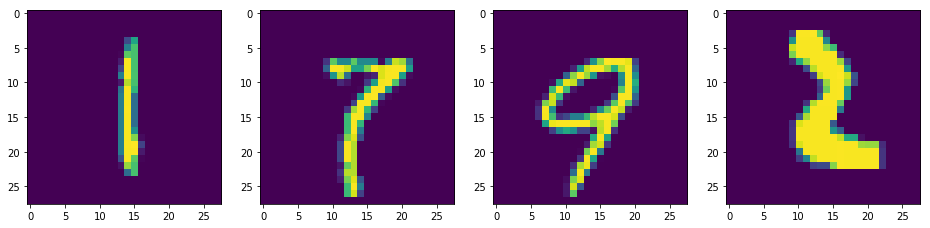

In [4]:
randomRow = np.random.randint(len(tr_x), size=4)
to_visualize = tr_x[randomRow,:]
imgList = []
plt.figure(figsize=[16,6])
for n,img in enumerate(to_visualize):
    plt.subplot(1,4,n+1)
    plt.imshow(img.reshape(28,28))


To train a convolutional neural network, we will need to reformat all data into 4-D tensor. Based on Udacity convolutional network.

In [5]:
image_size = 28
num_labels = 10
num_channels = 1

def reformat(dataset):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  return dataset

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def normalized(data):
    normal = []
    for jj in range(len(data)):
        normal.append([(x-128.)/128 for x in data[jj]])
    return normal

normal_tr_x = np.array(normalized(tr_x))
normal_v_x = np.array(normalized(v_x))
normal_ts = np.array(normalized(ts))

train_data = reformat(normal_tr_x)
train_label = tr_y
valid_data = reformat(normal_v_x)
valid_label = v_y
test_data = reformat(normal_ts)
print("Training data set {} - {}".format(train_data.shape,train_label.shape))
print("Validation data set {} - {}".format(valid_data.shape,valid_label.shape))
print("Test data set {} ".format(test_data.shape))

Training data set (33600, 28, 28, 1) - (33600, 10)
Validation data set (8400, 28, 28, 1) - (8400, 10)
Test data set (28000, 28, 28, 1) 


In [24]:
import tensorflow as tf

batch_size = 16
patch_size = 5
depth = 16
depth2 = 64
num_hidden = 64
l3_dropout = 0.75
depth2 = 64
beta_1 = 1e-5
beta_2 = 1e-5
beta_3 = 1e-5
beta_o = 1e-5


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_data)
  tf_test_dataset = tf.constant(test_data)
  
  #Another Way of Defining Variables
  weights = { # 5x5 conv2, 1 input, 16 output
              'l1_w' : tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth],stddev=0.1)),
              # 5x5 conv2, 16 input, 16 output
              'l2_w' : tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth2],stddev=0.1)),
              # fully connected, 7*7*16 = 784 input, 64 output
              'l3_w' : tf.Variable(tf.truncated_normal([image_size//4*image_size//4*depth2, num_hidden], stddev=0.1)),
              # output layer, 64 input, 10 output (class prediction)
              'o_w'  : tf.Variable(tf.truncated_normal([num_hidden, num_labels],stddev=0.1))}
  
  # shape of biases of each layer need to be the same as the output
  biases = { 'l1_b' : tf.Variable(tf.zeros([depth])),
             'l2_b' : tf.Variable(tf.constant(1.0, shape=[depth2])),
             'l3_b' : tf.Variable(tf.constant(1.0, shape=[num_hidden])),
             'o_b'  : tf.Variable(tf.constant(1.0, shape=[num_labels]))}

  def conv2d(x, W, b, strideC = 2):
    res = tf.nn.conv2d(x, W, [1,1,1,1],padding='SAME')
    res = tf.nn.relu(tf.nn.bias_add(res,b))
    return res

  def maxpool2d(x, k=2):
    res = tf.nn.max_pool(x, ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')
    return res
  
  def deep_convnet(x, weights, biases, dropout):
    # First convolution layer (l1)
    flow = conv2d(x,weights['l1_w'],biases['l1_b'])
    print ("after 1st convo",flow.get_shape())
    flow = maxpool2d(flow)
    print ("after 1st maxpool",flow.get_shape())
    
    # Second convolution layer (l2)
    flow = conv2d(flow,weights['l2_w'],biases['l2_b'])
    print ("after 2nd convo",flow.get_shape())
    flow = maxpool2d(flow)
    print ("after 2nd maxpool",flow.get_shape())
    
    # Reshaping layer (l3)
    shape = flow.get_shape().as_list()
    flow = tf.reshape(flow, [shape[0], shape[1] * shape[2] * shape[3]])
    print ("after reshape",flow.get_shape())
    flow = tf.nn.bias_add(tf.matmul(flow, weights['l3_w']), biases['l3_b'])
    flow = tf.nn.relu(flow)
    # Apply Dropout
    flow = tf.nn.dropout(flow,dropout)
    print ("after layer 3",flow.get_shape())
    
    # Output Layer (o)
    out = tf.nn.bias_add(tf.matmul(flow, weights['o_w']), biases['o_b'])
    print ("output layer",out.get_shape())
    return out 
    
  # Training computation.
  logits = deep_convnet(tf_train_dataset, weights, biases, l3_dropout)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Calculate the loss with regularization
  
  loss += beta_1 * tf.nn.l2_loss(weights['l1_w']) + \
    beta_2 * tf.nn.l2_loss(weights['l2_w']) + \
    beta_3 * tf.nn.l2_loss(weights['l3_w']) + \
    beta_o * tf.nn.l2_loss(weights['o_w'])
  
  
  # Learn with exponential rate decay.
  #global_step = tf.Variable(0, trainable=False)
  #starter_learning_rate = 0.4
  #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 100000, 0.96, staircase=True)
  learning_rate = 0.00146
  # Optimizer.
  optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(deep_convnet(tf_valid_dataset, weights, biases, l3_dropout))
  test_prediction = tf.nn.softmax(deep_convnet(tf_test_dataset, weights, biases, l3_dropout))

after 1st convo (16, 28, 28, 16)
after 1st maxpool (16, 14, 14, 16)
after 2nd convo (16, 14, 14, 64)
after 2nd maxpool (16, 7, 7, 64)
after reshape (16, 3136)
after layer 3 (16, 64)
output layer (16, 10)
after 1st convo (8400, 28, 28, 16)
after 1st maxpool (8400, 14, 14, 16)
after 2nd convo (8400, 14, 14, 64)
after 2nd maxpool (8400, 7, 7, 64)
after reshape (8400, 3136)
after layer 3 (8400, 64)
output layer (8400, 10)
after 1st convo (28000, 28, 28, 16)
after 1st maxpool (28000, 14, 14, 16)
after 2nd convo (28000, 14, 14, 64)
after 2nd maxpool (28000, 7, 7, 64)
after reshape (28000, 3136)
after layer 3 (28000, 64)
output layer (28000, 10)


In [32]:
num_steps = 2101
np.random.seed(42)


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  epoch = 11
  idx = np.arange(len(train_data))
  ii = 1
  X_tograph = []
  y_tograph = []
  for ii in range(epoch):
    #print("+++++++++++++++++++++++++++++++++++++++++++++++")
    np.random.shuffle(idx)
    train_datas = train_data[idx,:,:,:]
    train_labels = train_label[idx,:]
    for step in range(num_steps):
      offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
      batch_data = train_datas[offset:(offset + batch_size), :, :, :]
      batch_labels = train_labels[offset:(offset + batch_size), :]
      feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
      _, l, predictions = session.run(
        [optimizer, loss, train_prediction], feed_dict=feed_dict)
    #if (ii % 10 == 0):
    print('+++++++++++++++Running the {} epoch+++++++++++++'.format(ii))  
    print('Minibatch loss at end epoch %d: %f' % (ii, l))
    print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    print('Validation accuracy: %.1f%%' % accuracy(
            valid_prediction.eval(), valid_label))
    print("+++++++++++++++++++++++++++++++++++++++++++++++")
    X_tograph.append(ii)
    y_tograph.append(accuracy(valid_prediction.eval(), valid_label))
  #save_path = saver.save(session, "/tmp/DR_model_adam.ckpt")
  #print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  result = test_prediction.eval()

Initialized
+++++++++++++++Running the 0 epoch+++++++++++++
Minibatch loss at end epoch 0: 0.021770
Minibatch accuracy: 100.0%
Validation accuracy: 96.7%
+++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++Running the 1 epoch+++++++++++++
Minibatch loss at end epoch 1: 0.119963
Minibatch accuracy: 100.0%
Validation accuracy: 97.5%
+++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++Running the 2 epoch+++++++++++++
Minibatch loss at end epoch 2: 0.020681
Minibatch accuracy: 100.0%
Validation accuracy: 98.2%
+++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++Running the 3 epoch+++++++++++++
Minibatch loss at end epoch 3: 0.043843
Minibatch accuracy: 100.0%
Validation accuracy: 98.2%
+++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++Running the 4 epoch+++++++++++++
Minibatch loss at end epoch 4: 0.012804
Minibatch accuracy: 100.0%
Validation accuracy: 98.5%
+++++++++++++++++++++++++++++++++++++++++++++++
+++++++++++++++Running the 5 epoch++++

In [20]:
print(tf.__version__)

1.13.1


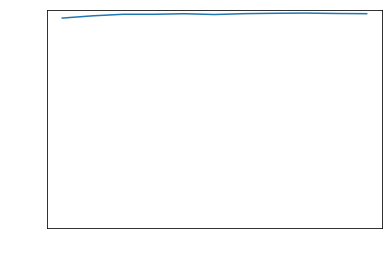

In [33]:
%matplotlib inline
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(X_tograph, y_tograph)
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation Accuracy")
ax.set_ylim((0,100))

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()

In [35]:
def getitem(a):
    return max(range(len(a)),key=a.__getitem__)

a = getitem(result[0])
res = [getitem(result[ii]) for ii in range(len(result))]
idd = np.arange(1,len(res)+1)

df_res = pd.DataFrame()
df_res['ImageId']= idd
df_res['Label']=res
print(df_res.head())
df_res.to_csv("DR_submission_jimmy_jiang4.csv",index=False)

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
